# Property insurance risk assessment: 
using public data to estimate building features that affect insurance value


In [20]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
for dirname, _, filenames in os.walk('D:/1999Faye/自我拓展！/Python/SVM支持向量机'):
    for filename in filenames:
        os.path.join(dirname, filename)
import cv2
from tqdm import tqdm

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


## Part 1: Self-constructed CNN model

### Define the constant

In [21]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Pair the image label

<AxesSubplot:>

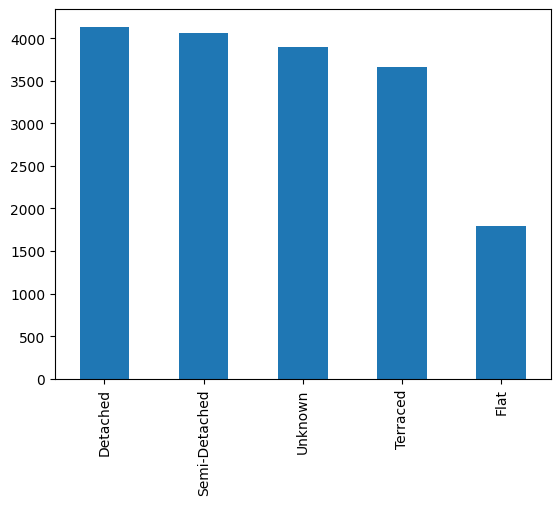

In [22]:
# loading the file name of the image
# filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view")
filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example")
pro = pd.read_csv("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/properties.csv")
pro['property_id'] = 'gsv_' + pro['property_id'] + '.jpg'
pro['propertyType'].value_counts().plot.bar()

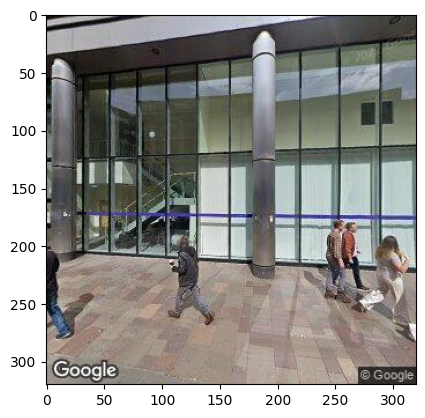

In [23]:
sample = random.choice(filenames)
image = load_img("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/"+sample)
plt.imshow(image)

### Spliting the train and test set

In [24]:
train, test = train_test_split(pro, test_size=0.20, random_state=33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [25]:
train.head()

,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"Weald Barn House, Wierton Hill, Boughton Monch...",Semi-Detached,4.0,https://www.rightmove.co.uk/house-prices/detai...,51.21990,0.54807,gsv_6f9797e6-917c-428e-a3cb-5a12fa7736b3.jpg
1,0,"Braeside, Langlee, Jedburgh, Roxburghshire TD8...",Unknown,NaN,https://www.rightmove.co.uk/house-prices/detai...,55.45179,-2.56030,gsv_31139028-3fe2-4526-8f7d-40be5d1dc352.jpg
2,0,"40, Noel Gate, Aughton, Ormskirk, Lancashire L...",Semi-Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,53.55175,-2.91041,gsv_d6b07a47-7c1a-49bb-93ab-be6ac539bb94.jpg
3,0,"42, Windsor Road, Levenshulme, Manchester, Gre...",Semi-Detached,5.0,https://www.rightmove.co.uk/house-prices/detai...,53.44540,-2.19629,gsv_42d66d7e-e5aa-4baf-957f-20339589be28.jpg
4,0,"3, Maesyllan, Llansilin, Oswestry, Powys SY10 7QE",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,52.84316,-3.17405,gsv_f8884edb-6cea-400a-94b7-5d4e14e1eeef.jpg


<AxesSubplot:>

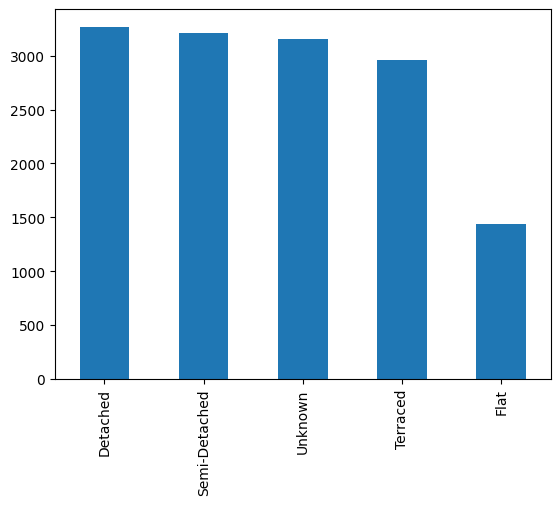

In [26]:
train['propertyType'].value_counts().plot.bar()

<AxesSubplot:>

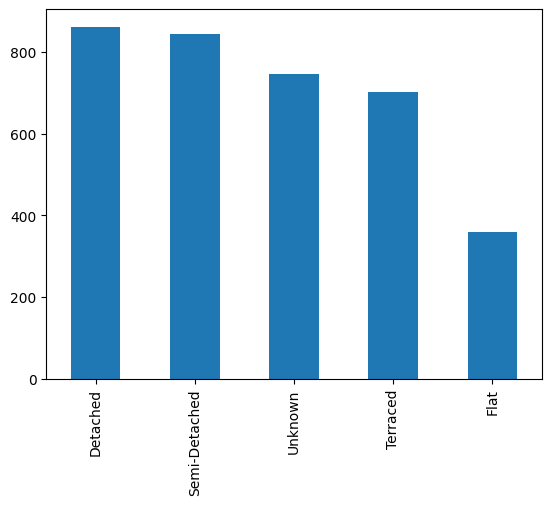

In [27]:
test['propertyType'].value_counts().plot.bar()

In [28]:
train_num = train.shape[0]
test_num = test.shape[0]
# In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
# batch_size=64
batch_size=64
# The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.
# epochs=100
epochs=50

### Building CNN model

In [29]:
model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 159, 159, 32)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 78, 78, 64)       

### Prevent over-fitting: callback

In [18]:
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

In [19]:
# We will reduce the learning rate when then accuracy not increase for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

In [20]:
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop]

### Image generator

In [21]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2034 validated image filenames belonging to 5 classes.


In [22]:
test_idg = ImageDataGenerator(rescale=1./255)
test_imagegenerator = test_idg.flow_from_dataframe(
    test, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 516 validated image filenames belonging to 5 classes.


In [19]:
# # example: 

# example_df = train.sample(n=1).reset_index(drop=True)
# example_generator = train_idg.flow_from_dataframe(
#     example_df, 
#     "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [20]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

### Fit on the Training set and make predcitons on the Validation set

In [21]:

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=test_imagegenerator,
    # validation_steps=test_num//batch_size,
    # steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)




Epoch 1/50
32/32 [==============================] - 146s 4s/step - loss: 3.1439 - accuracy: 0.2301 - val_loss: 1.6040 - val_accuracy: 0.2539 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 142s 4s/step - loss: 1.5784 - accuracy: 0.2483 - val_loss: 1.5702 - val_accuracy: 0.2771 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 141s 4s/step - loss: 1.5183 - accuracy: 0.3107 - val_loss: 1.5464 - val_accuracy: 0.2888 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 143s 4s/step - loss: 1.4848 - accuracy: 0.3235 - val_loss: 1.5525 - val_accuracy: 0.2849 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 147s 5s/step - loss: 1.4790 - accuracy: 0.3319 - val_loss: 1.5191 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 142s 4s/step - loss: 1.4627 - accuracy: 0.3353 - val_loss: 1.5022 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 141s 4s/step - loss: 1.4

### Visualize the result

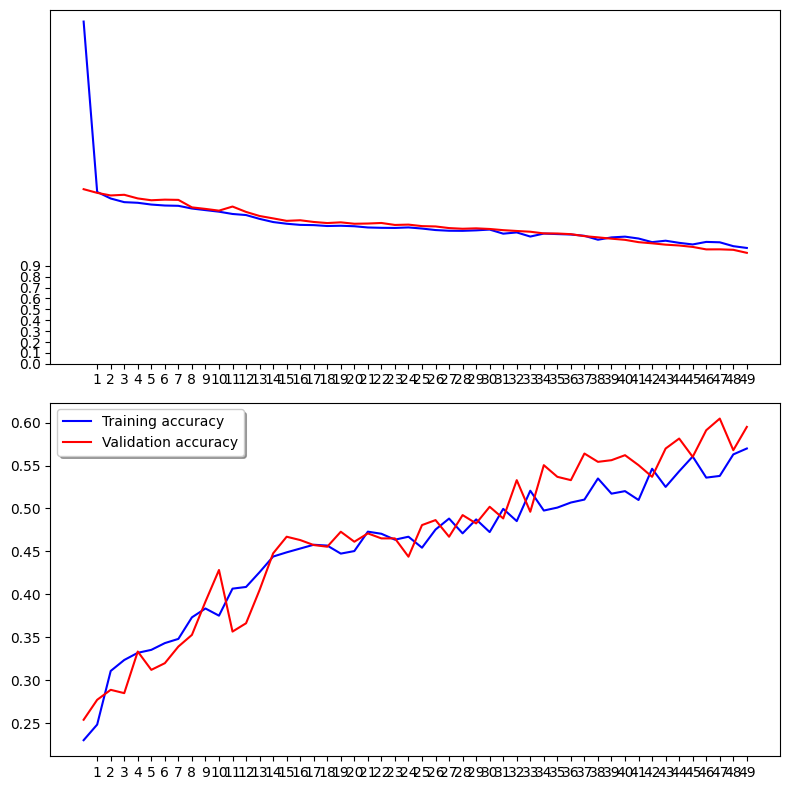

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Part2: 分类是否有房子

手动分类2000多张图片，然后利用SVM将剩下的所有图片分类为【house/not_houst】


#### Building SVM model

SVM algorithm is to be used when their is shortage of data in our dataset

In [23]:
DATADIR = 'D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_svm'
Label = ['house','not_house']

IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

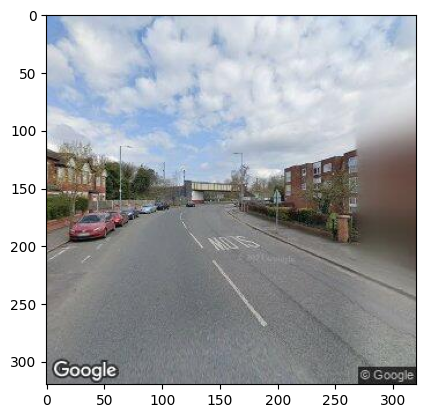

In [24]:
# show a pic
for category in Label:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=load_img(os.path.join(path,img))
        
        
        plt.imshow(img_array)
        # plt.imshow(img_array)
        plt.show()
        
        break
    break

In [25]:
import glob
all_data=[]
for category in Label:
    path=os.path.join(DATADIR, category)
    # img_path = glob.glob(path+'/*.jpg')
    class_num=Label.index(category)
    # for img in img_path:
    for img in os.listdir(path):
        # img_array=cv2.imread(img)
        img_array=cv2.imread(os.path.join(path,img))
        
        all_data.append([img_array,class_num])

img_num = len(all_data)

In [26]:
# X should be of type (training_data_length , -1) because SVM takes 2D input to train 

X=[]
y=[]

for categories, label in all_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(img_num,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

X.shape

(90, 307200)

In [27]:
# flattening the array
X = X/255.0

In [28]:
y=np.array(y)
y.shape

(90,)

split the train and validation data

In [29]:
# applying train_test_split on our data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

fit the model

In [30]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [31]:
# use gridsearchcv to automatically choose the parameters for SVM
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear', 'rbf','poly']}
svc=svm.SVC(probability=True)
svm_model=GridSearchCV(svc,param_grid)

svm_model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']})

evaluate the model use validation set

In [32]:
pre_test_y = svm_model.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy on validation set is",accuracy_score(y_test,pre_test_y))

Accuracy on validation set is 0.782608695652174


The accuracy of predicting the house/not_house is around 80% by using SVM. Then try to use CNN to do the image classification. 

#### Building CNN model

In [6]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [30]:
files = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label")
label = []
for img in files:
    category = img.split('.')[0]
    if category == 'house':
        label.append('house')
    else:
        label.append('not_house')

df = pd.DataFrame({
    'filename': files,
    'category': label
})

df

,filename,category
0,house.1.jpg,house
1,house.10.jpg,house
2,house.100.jpg,house
3,house.1000.jpg,house
4,house.1001.jpg,house
...,...,...
2545,not_house.95.jpg,not_house
2546,not_house.96.jpg,not_house
2547,not_house.97.jpg,not_house
2548,not_house.98.jpg,not_house


In [8]:
# Use the VGG16 model to do the image classification. 

VGGmodel = Sequential()
VGGmodel.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Flatten())
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=2, activation="softmax"))

VGGmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
VGGmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [31]:
# Control the training

# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
# early = EarlyStopping(monitor='val_acc', verbose=1, mode='auto')

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [32]:
train_house, validate_house = train_test_split(df, test_size=0.20, random_state=22)
train_house = train_house.reset_index(drop=True)
validate_house = validate_house.reset_index(drop=True)

num_train = train_house.shape[0]
num_validate = validate_house.shape[0]
batch_size=32

In [11]:
# Generate the training image
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_housegenerator = train_idg.flow_from_dataframe(
    train_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2040 validated image filenames belonging to 2 classes.


In [12]:
test_idg = ImageDataGenerator(rescale=1./255)

test_housegenerator = test_idg.flow_from_dataframe(
    validate_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 510 validated image filenames belonging to 2 classes.


In [14]:
# Fit the model
epochs=50
history_house = VGGmodel.fit_generator(
    steps_per_epoch=10, 
    generator = train_housegenerator, 
    epochs=50,
    validation_data=test_housegenerator,
    validation_steps=10, 
    callbacks=[checkpoint,early]
)


Epoch 1/50
10/10 [==============================] - 128s 13s/step - loss: 0.5896 - accuracy: 0.8656 - val_loss: 0.5191 - val_accuracy: 0.8594
Epoch 2/50
10/10 [==============================] - 127s 13s/step - loss: 0.4443 - accuracy: 0.8687 - val_loss: 0.4174 - val_accuracy: 0.8562
Epoch 3/50
10/10 [==============================] - 125s 13s/step - loss: 0.3874 - accuracy: 0.8718 - val_loss: 0.3731 - val_accuracy: 0.8813
Epoch 4/50
10/10 [==============================] - 128s 13s/step - loss: 0.4418 - accuracy: 0.8406 - val_loss: 0.3924 - val_accuracy: 0.8719
Epoch 5/50
10/10 [==============================] - 130s 13s/step - loss: 0.3605 - accuracy: 0.8844 - val_loss: 0.3929 - val_accuracy: 0.8719
Epoch 6/50
10/10 [==============================] - 127s 13s/step - loss: 0.3681 - accuracy: 0.8813 - val_loss: 0.3830 - val_accuracy: 0.8719
Epoch 7/50
10/10 [==============================] - 126s 13s/step - loss: 0.3836 - accuracy: 0.8719 - val_loss: 0.4004 - val_accuracy: 0.8625
Epoch 

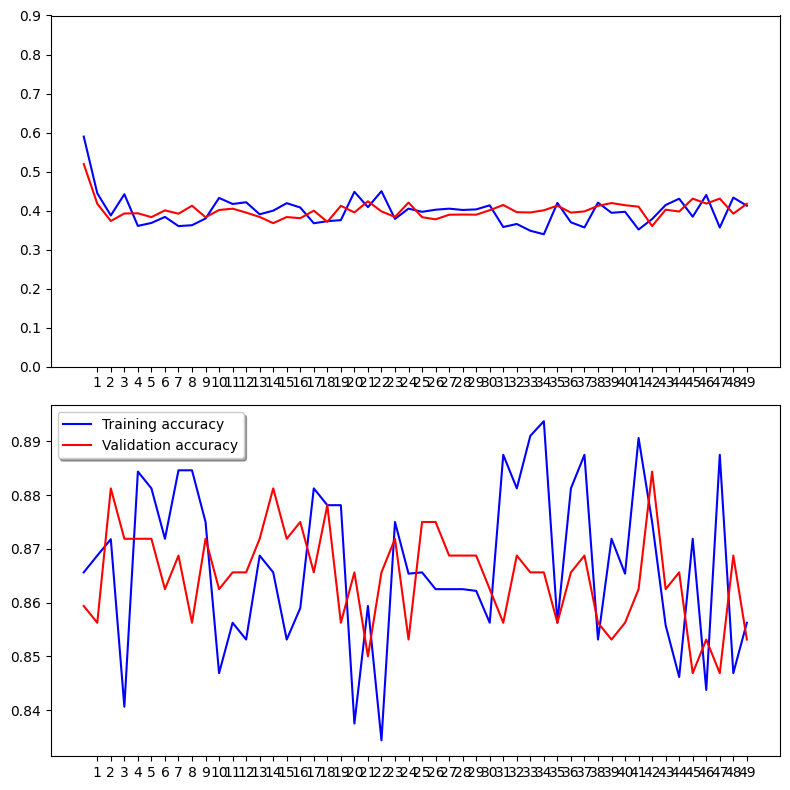

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history_house.history['loss'], color='b', label="Training loss")
ax1.plot(history_house.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_house.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_house.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

We enconter a problem of over-fitting

In [35]:
model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 159, 159, 32)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 78, 78, 64)       

In [36]:
# Try original self-constructed model
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Generate the training image
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_housegenerator = train_idg.flow_from_dataframe(
    train_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_idg = ImageDataGenerator(rescale=1./255)

test_housegenerator = test_idg.flow_from_dataframe(
    validate_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# Fit the model
epochs=50
history_house2 = model.fit_generator(
    steps_per_epoch=10, 
    generator = train_housegenerator, 
    epochs=epochs,
    validation_data=test_housegenerator,
    validation_steps=10, 
    callbacks=[checkpoint,early]
)


Found 2040 validated image filenames belonging to 2 classes.
Found 510 validated image filenames belonging to 2 classes.
Epoch 1/50
10/10 [==============================] - 35s 3s/step - loss: 1.7848 - accuracy: 0.7437 - val_loss: 0.4738 - val_accuracy: 0.8531
Epoch 2/50
10/10 [==============================] - 33s 3s/step - loss: 0.4134 - accuracy: 0.8625 - val_loss: 0.3759 - val_accuracy: 0.8813
Epoch 3/50
10/10 [==============================] - 33s 3s/step - loss: 0.3780 - accuracy: 0.8687 - val_loss: 0.4467 - val_accuracy: 0.8594
Epoch 4/50
10/10 [==============================] - 33s 3s/step - loss: 0.3127 - accuracy: 0.8938 - val_loss: 0.4604 - val_accuracy: 0.8562
Epoch 5/50
10/10 [==============================] - 33s 3s/step - loss: 0.3288 - accuracy: 0.8781 - val_loss: 0.4051 - val_accuracy: 0.8687
Epoch 6/50
10/10 [==============================] - 33s 3s/step - loss: 0.3204 - accuracy: 0.8750 - val_loss: 0.4800 - val_accuracy: 0.8813
Epoch 7/50
10/10 [=====================

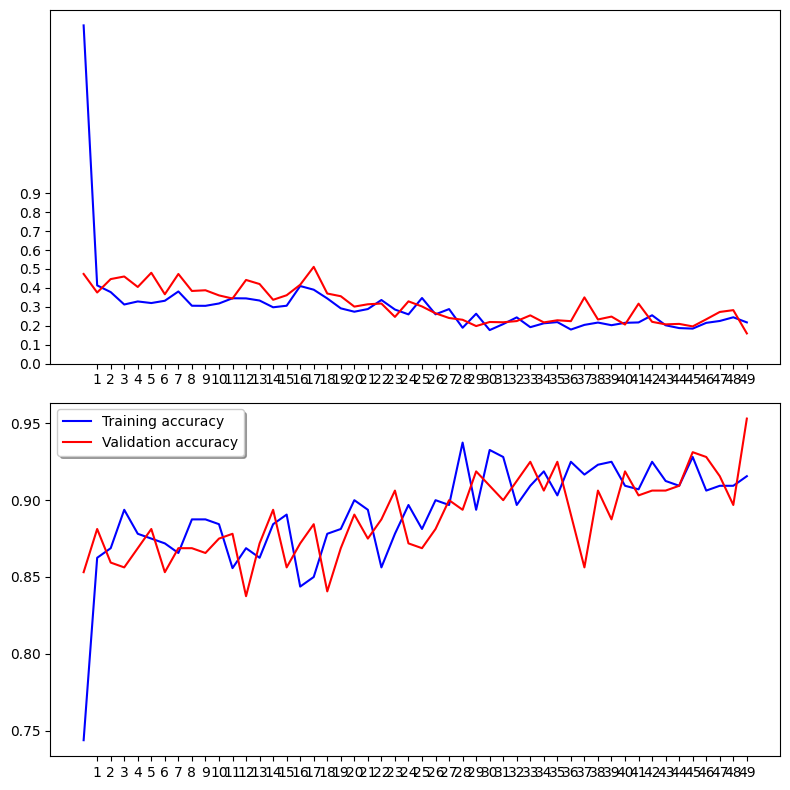

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history_house2.history['loss'], color='b', label="Training loss")
ax1.plot(history_house2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_house2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_house2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()